In [1]:
"""
Notation used in this notebook

ells            - array of ells to Lmax
pcls            - C_ells defined through a power law
check_cls       - C_ells from anafast on a map

sbb             - amplitude map/template map
beta_map        - map of the varying beta

sed_scaling_<x> - scaled_synch function on frequencies. nu^beta_map

newmaps_<x>     - template map * sed_scaling map. Series of freq maps

""";

In [64]:
%load_ext autoreload
# to make modification in .py file type %autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
%load_ext line_profiler
#for finding out how long code takes to run

In [91]:
#trying to consolidate the work so far into a cohesive document and notation. Pushing definitions into 
#separate .py file

#------packages-------------------
%pylab inline
import time
import healpy as hp
import foreground_functions as ff

#-------BB parameters (to start)--------
A_BB = 1.7e3
alpha_BB = -3.0
beta_BB = -3.2
beta_sigma = 1.5e-6
nu0 = 2.3e9

#-------map paramters--------------------
nside = 128
Lmax = 384
ell_sum_384 = 384
ell_sum_800 = 800
ells = np.arange(1,Lmax+1)
extended_ells = np.arange(1,ell_sum_800+1)

#define list of frequencies going from 10 to 300 GHz, sampling 20 points
freqs = np.linspace(30,300,4)*1.e9

#---realisations
N=100

Populating the interactive namespace from numpy and matplotlib


In [92]:
%autoreload

In [93]:
#an example of how to get diagnostics on functions
#%lprun -f ff.generate_map_full ff.generate_map_full(384, A_BB, alpha_BB, beta_sigma, freqs, nu0)

In [94]:
start=time.time()
instance = ff.realisation(N, freqs)
end = time.time()
print(end-start)

80.6606457233429


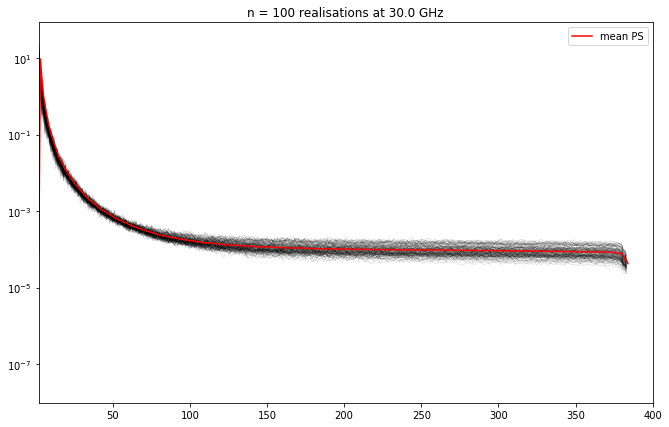

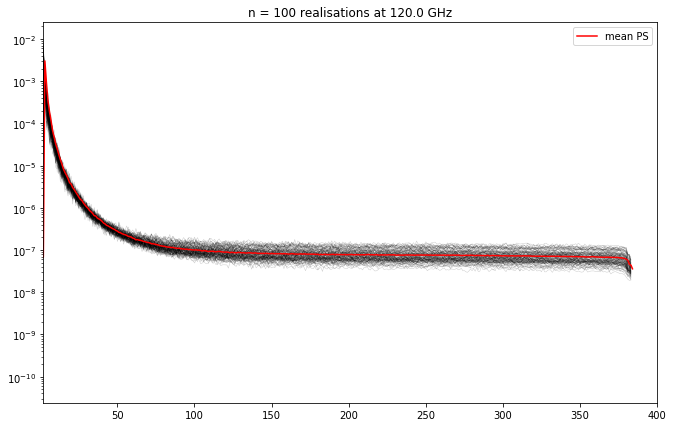

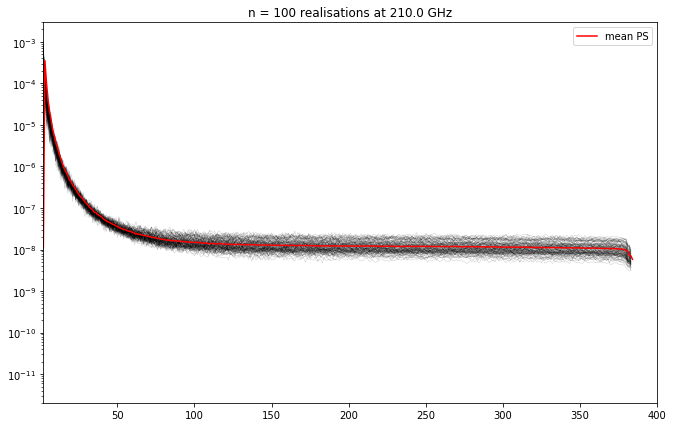

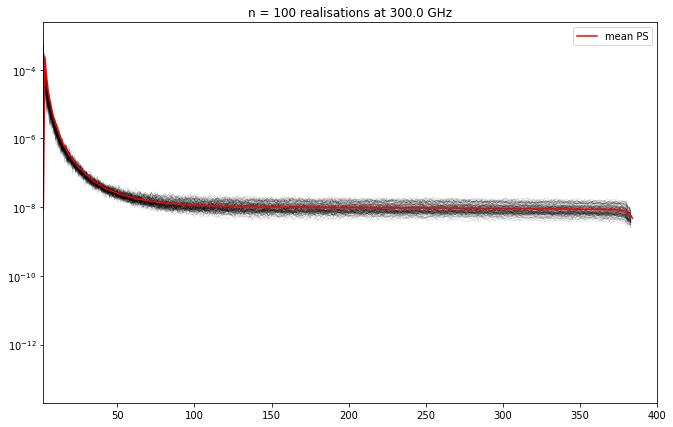

In [95]:
mean_ps = np.mean(instance,0)

for i in range(len(freqs)):
    figure(figsize=(11,7))
    
    for j in range(N):
        semilogy(instance[j,:,i], 'k', alpha = 0.2, lw=.5)
        
    semilogy(ells, mean_ps[:,i], 'r', label='mean PS')
    xlim(2,400)
    title('n = ' + str(100) + ' realisations at ' + str(np.round(1e-9*freqs[i])) + ' GHz')
    legend();

In [96]:
#define pcls, bcls, and the 0x0 and 1x1 moment

start=time.time()

pcls = A_BB * ff.powerlaw(ells, alpha_BB)
pcls[0] = 0
sed_scaling = ff.scale_synch(freqs, beta_BB)

bcls = beta_sigma * np.ones_like(ells)  
beta_map = hp.synfast(bcls, nside, new=True, verbose=False)
beta_map -= (np.mean(beta_map) + 3.2)

#-----Define the moments----------------------------------
#-----0x0 moment------------------------------------------
#define a matrix to hold all the 0x0 moments at diff freqs
moment0x0 = np.zeros((len(freqs),len(ells)))
for i in range(len(moment0x0[:,i])):
    moment0x0[i] = pcls * sed_scaling[i]**2
    
#-----1x1 moment------------------------------------------

synch_cls = A_BB * ff.powerlaw(extended_ells, alpha_BB)
synch_cls[0] = 0
beta_cls = beta_sigma * ones_like(extended_ells)

wignersum_384 = ff.get_wigner_sum(ell_sum_384, synch_cls, beta_cls)
# wignersum_800 = ff.get_wigner_sum(ell_sum_800, synch_cls, beta_cls)

moment1x1_384 = np.zeros((len(freqs),len(ells)))
# moment1x1_800 = np.zeros((len(freqs),len(ells)))

for i in range(len(moment1x1_384[:,0])):
    moment1x1_384[i] =  log(freqs[i]/nu0)**2 * sed_scaling[i]**2 * wignersum_384[:Lmax] 

# for i in range(len(moment1x1_800[:,i])):
#     moment1x1_800[i] =  log(freqs[i]/nu0)**2 * sed_scaling[i]**2 * wignersum_800[:Lmax] 


end=time.time()
print(end-start)

6.19740891456604


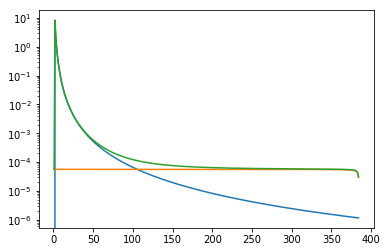

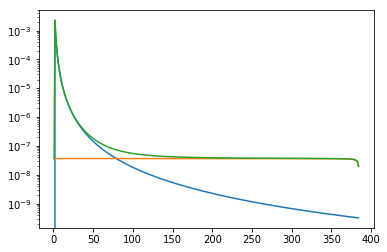

In [97]:
for k in range(2):
    figure()
    mom0x0 = moment0x0[k]
    mom1x1 = moment1x1_384[k]
    
    semilogy(ells, mom0x0)
    semilogy(ells, mom1x1)
    semilogy(ells, mom0x0+mom1x1)

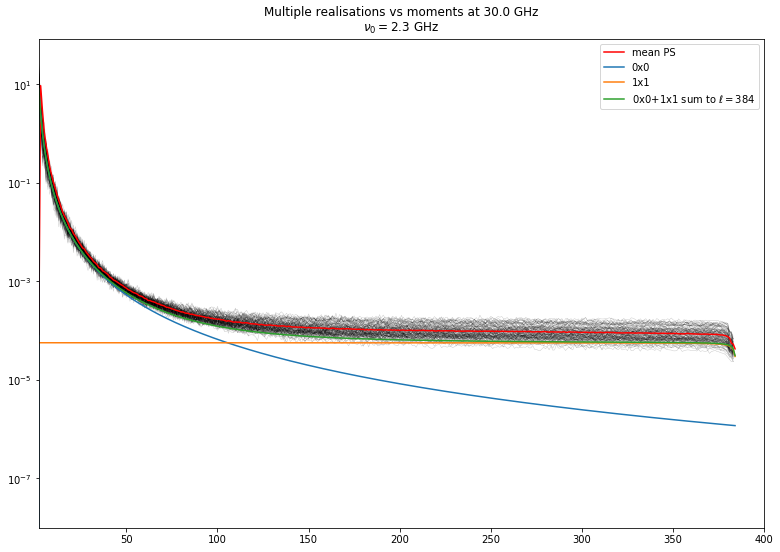

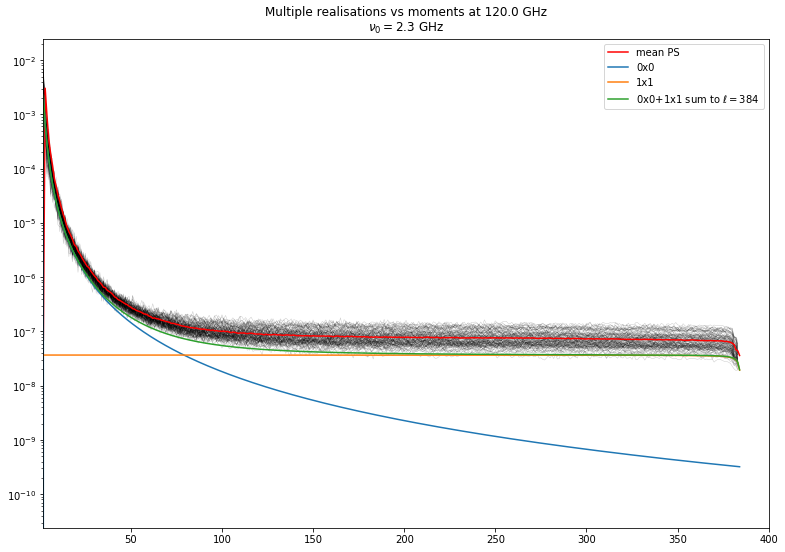

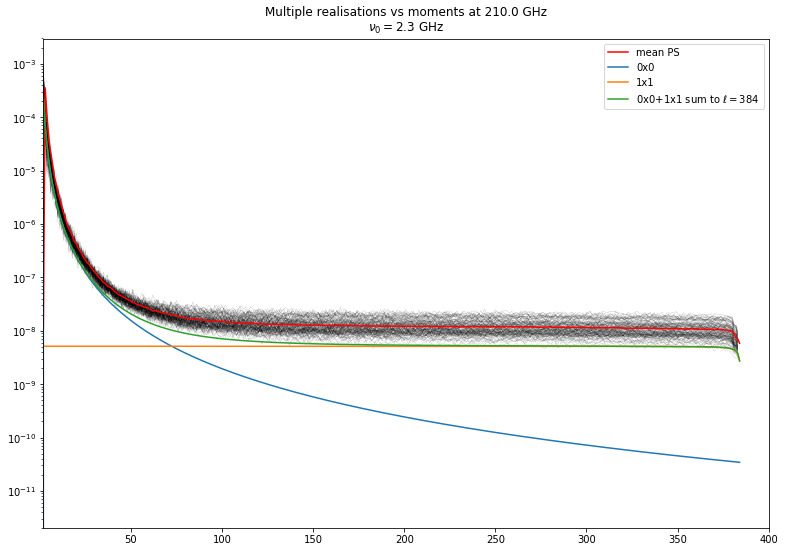

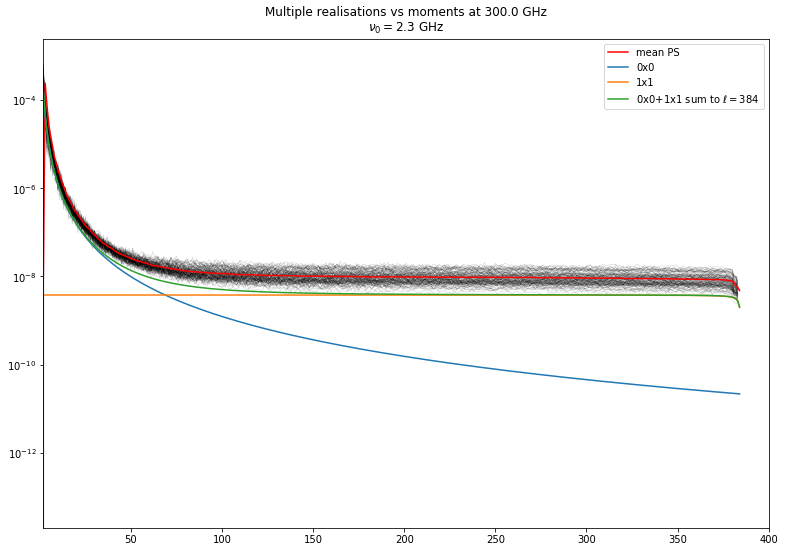

In [99]:
#overplot the realisations with the model
for i in range(len(freqs)):
    figure(figsize=(13,9))
    
    for j in range(N):
        semilogy(instance[j,:,i], 'k', alpha = 0.2, lw=.5)
        
    semilogy(ells, mean_ps[:,i], 'r', label='mean PS')
    
    mom0x0 = moment0x0[i]
    mom1x1_384 = moment1x1_384[i]
#     mom1x1_800 = moment1x1_800[i]
    
    semilogy(ells, mom0x0, label='0x0')
    semilogy(ells, mom1x1_384, label='1x1')
    semilogy(ells, mom0x0+mom1x1_384, label=r'0x0+1x1 sum to $\ell = 384$')
#     semilogy(ells, mom0x0+mom1x1_800, label=r'0x0+1x1 sum to $\ell = 800$')
    xlim(2,400)
    title('Multiple realisations vs moments at ' + str(np.round(freqs[i]*1e-9)) + ' GHz' "\n" r'$\nu_0=2.3 \ \rm GHz$')
    legend();

# Code up the 0x2 moment

from paper know
$$
C_\ell^{\nu_1\nu_2}(0\times 2) = \frac{1}{2} \left[ \mathrm{Sy}^{\nu_1}\partial_\beta^2 \mathrm{Sy}^{\nu_2} + \mathrm{Sy}^{\nu_2}\partial_\beta^2 \mathrm{Sy}^{\nu_1} \right] \langle \mathrm{Sy}^2\rangle_\ell \sum_{\ell_1 = 0}^{\ell_{max}} \frac{2 \ell_1 + 1}{4\pi}\langle \beta^2 \rangle_{\ell_1}
$$

translate into code and use power laws
$$
C_\ell^{\nu_1\nu_2}(0\times 2) = \frac{1}{2} \mathrm{SED}^{\nu_1} \mathrm{SED}^{\nu_2}\left[ \left(\ln\left(\frac{\nu_1}{\nu_0}\right)\right)^2 + \left(\ln\left(\frac{\nu_2}{\nu_0}\right)\right)^2\right] \langle      \underbrace{\texttt{amp_map}^2\rangle_\ell}_{\texttt{pcls}} \sum_{\ell_1 = 0}^{\ell_{max}} \frac{2 \ell_1 + 1}{4\pi}\underbrace{\langle \texttt{beta_map}^2 \rangle_{\ell_1}}_{\texttt{beta_cls}}
$$

for auto spectra this is the same as the 1x1 moment (prop to log(x)^2 SED^2) up to the different sum

In [102]:
#write a function to perform the 0x2 sum
def mom0x2_sum(ell_max, bcls):
    sum = 0
    for ell1 in range(int(ell_max)):
        sum += (2*ell1 + 1)/(4*pi) * bcls[ell1]
    return sum

Text(0, 0.5, '0x2 sum')

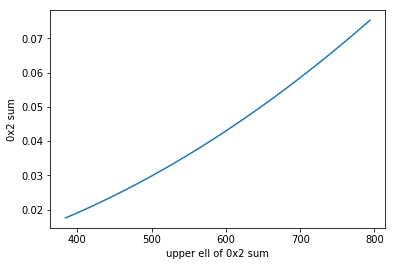

In [106]:
#how does mom0x2 depend on upper limit of sum?
y = []
for i in range(384, 800, 10):
    y_i = mom0x2_sum(i, beta_cls)
    y.append(y_i)

x = range(384, 800, 10)
plot(x, y)
xlabel('upper ell of 0x2 sum')
ylabel('0x2 sum')

In [57]:
#that's not good.......

In [ ]:
#the beta_cls by assumption are constant, not decreasing, so the 0x2 sum diverges...

In [127]:
def mom0x2_test_sum(ell_sum, beta_sigma):
    sum = 0
    for ell1 in range(ell_sum):
        sum += (2*ell1 + 1)/(4*pi) * beta_sigma
    return sum

In [128]:
test = mom0x2_test_sum(10000, beta_sigma)

In [129]:
print(test)

11.936620731892154


In [114]:
mom0x2sum = mom0x2_sum(ell_sum_384, beta_cls)
moment0x2_384 = np.zeros((len(freqs),len(ells)))
# moment0x2_800 = np.zeros((len(freqs),len(ells)))


for i in range(len(moment0x2_384[:, 0])): #for each frequency
    moment0x2_384[i] =  log(freqs[i]/nu0)**2 * sed_scaling[i]**2 * mom0x2sum

# for i in range(len(moment0x2_800[:,0])):
#     moment0x2_800[i] =  log(freqs[i]/nu0)**2 * sed_scaling[i]**2 * mom0x2sum

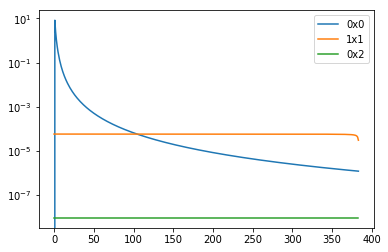

In [121]:
semilogy(moment0x0[0], label = '0x0')
semilogy(moment1x1_384[0], label = '1x1')
semilogy(moment0x2_384[0], label = '0x2')
legend();

In [22]:
#two problems
#1. this sum is more sensitive to the number of terms in it
#2. the 0x2 term appears to be ~4 orders smaller than the 1x1 term...

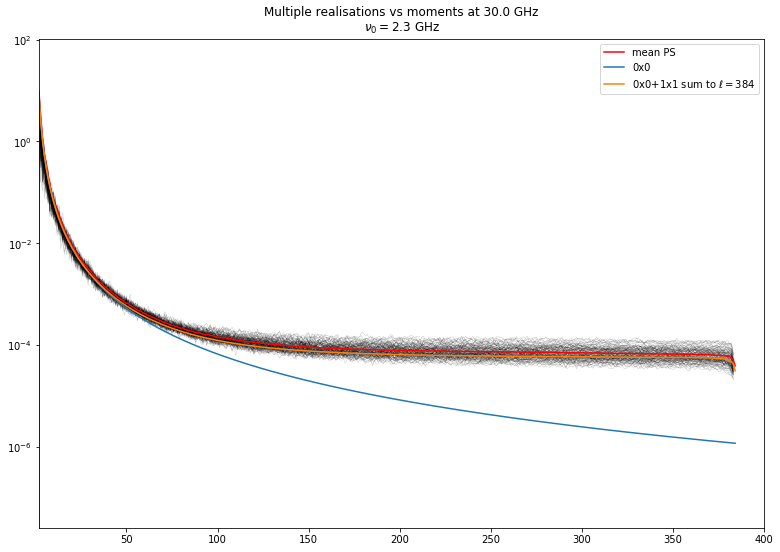

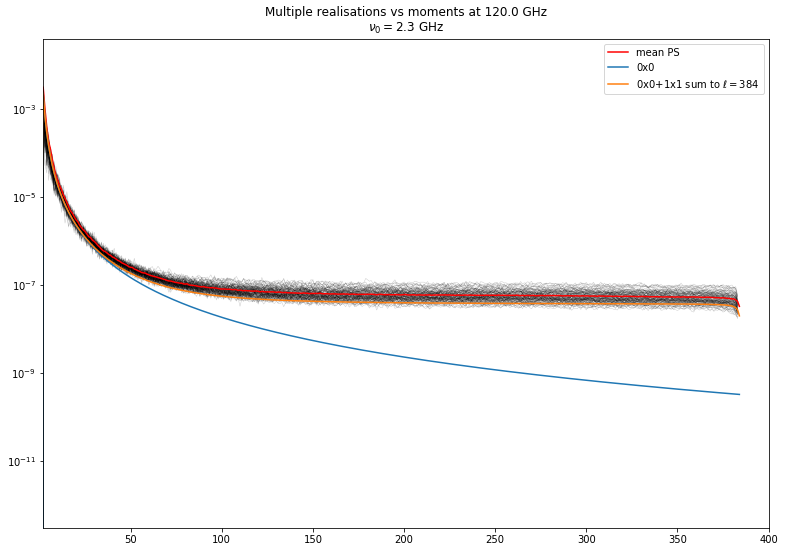

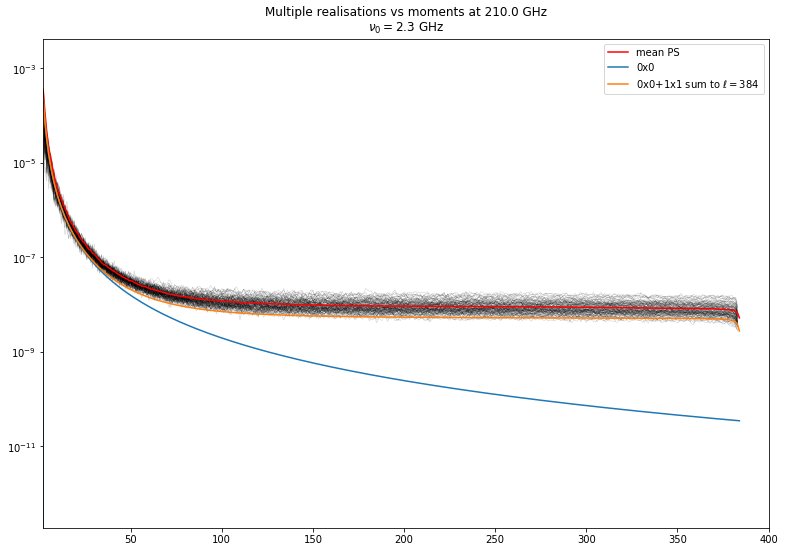

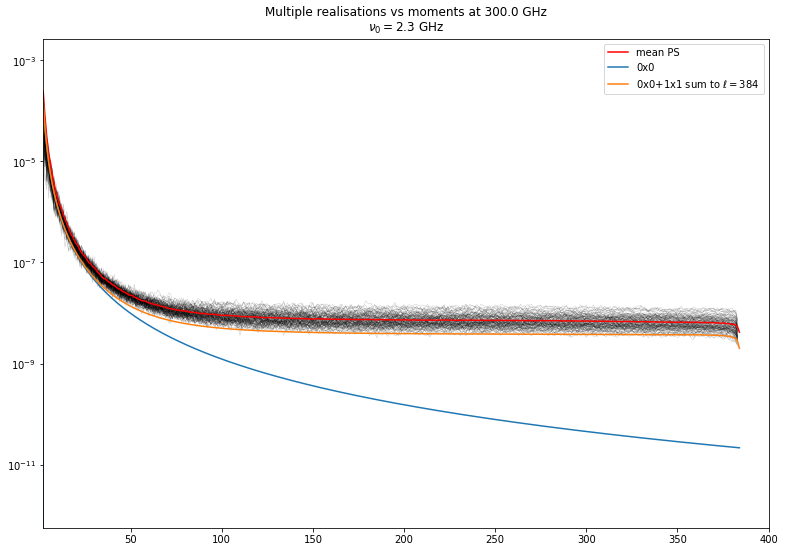

In [60]:
#overplot the realisations with the model
for i in range(len(freqs)):
    figure(figsize=(13,9))
    
    for j in range(N):
        semilogy(instance[j,:,i], 'k', alpha = 0.2, lw=.5)
        
    semilogy(ells, mean_ps[:,i], 'r', label='mean PS')
    
    mom0x0 = moment0x0[i]
    mom1x1_384 = moment1x1_384[i]
    mom1x1_800 = moment1x1_800[i]
    mom0x2_384 = moment0x2_384[i]
    mom0x2_800 = moment0x2_800[i]
    
    semilogy(ells, mom0x0, label='0x0')
#     semilogy(ells, mom1x1, label='1x1')
#     semilogy(ells, mom0x0+mom0x2_384, label=r'0x0+0x2 sum to $\ell = 384$')
    semilogy(ells, mom0x0+mom1x1_384, label=r'0x0+1x1 sum to $\ell = 384$')
#     semilogy(ells, mom0x0+mom1x1_384+mom0x2_384, label=r'0x0+1x1+0x2 sum to $\ell = 384$')
#     semilogy(ells, mom0x0+mom1x1_800, label=r'0x0+1x1 sum to $\ell = 800$')
    xlim(2,400)
    title('Multiple realisations vs moments at ' + str(np.round(freqs[i]*1e-9)) + ' GHz' "\n" r'$\nu_0=2.3 \ \rm GHz$')
    legend();

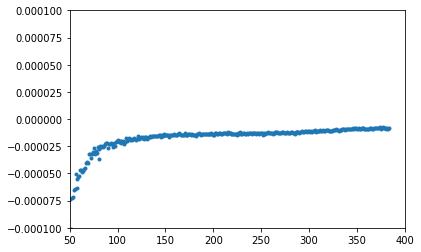

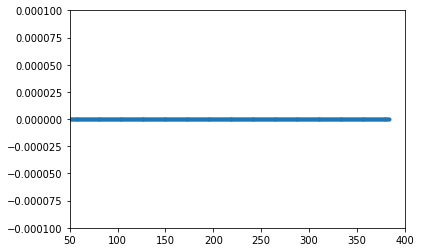

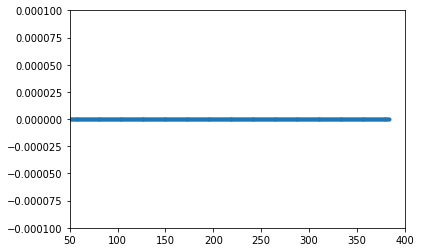

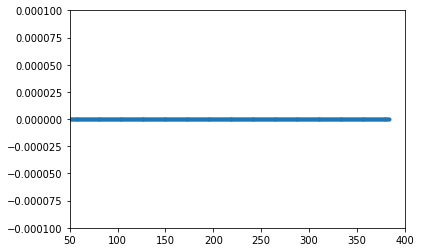

In [28]:
#plot some residuals
for i in range(len(freqs)):
    figure()
    resid = moment0x0[i] + moment1x1_384[i] - mean_ps[:,i]
    plot(ells, resid, '.')
    xlim(50,400)
    y = 1e-4
    ylim(-y,y)